# 1. Import necessary libraries and datasets and Extract input and target variables :
In this cell We import the required Python libraries for data manipulation and visualization, and load the training, validation, and test datasets.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
train_data = np.load('train.npz')
val_data = np.load('val.npz')
test_data = np.load('test.npz')

X_train, Y_train = train_data['x'], train_data['y']
X_val, Y_val = val_data['x'], val_data['y']
X_test, Y_test = test_data['x'], test_data['y']

print(f"Training data shape: X_train {X_train.shape}, Y_train {Y_train.shape}")
print(f"Validation data shape: X_val {X_val.shape}, Y_val {Y_val.shape}")
print(f"Test data shape: X_test {X_test.shape}, Y_test {Y_test.shape}")

Training data shape: X_train (3023, 19, 128, 2), Y_train (3023, 1, 128, 2)
Validation data shape: X_val (431, 19, 128, 2), Y_val (431, 1, 128, 2)
Test data shape: X_test (864, 19, 128, 2), Y_test (864, 1, 128, 2)


# 2.  Creating Windowed Sequences for Time Series Forecasting :
 In this Cell, we transform our raw time series data into a format suitable for training our forecasting model. We use a technique called sliding window to create overlapping sequences from the data. Each input sequence (in X_windows) represents a window of past data, while the corresponding target sequence (in Y_windows) represents the values we want to predict. This allows our model to learn from past patterns and relationships to forecast future traffic conditions.

In [ ]:
def create_windows(train_data, labels, window_size, predict_horizon):
    X_windows = []
    Y_windows = []

    for i in range(len(train_data) - window_size - predict_horizon):
        X_window = train_data[i:i + window_size]
        Y_window = labels[i + window_size:i + window_size + predict_horizon]
        X_windows.append(X_window)
        Y_windows.append(Y_window)

    return np.array(X_windows), np.array(Y_windows)


# 3. Creating Tensors and DataLoaders :
Now that we have our windowed sequences, we convert them into PyTorch tensors, which are the standard data structure for working with deep learning models in PyTorch. We also create DataLoaders for our training, validation, and test sets. DataLoaders provide a convenient way to iterate through the data in batches during the training and evaluation processes.

In [ ]:
import torch

window_size = 10
predict_horizon = 5

X_train_windows, Y_train_windows = create_windows(X_train, Y_train, window_size, predict_horizon)
X_val_windows, Y_val_windows = create_windows(X_val, Y_val, window_size, predict_horizon)
X_test_windows, Y_test_windows = create_windows(X_test, Y_test, window_size, predict_horizon)

X_train_tensor = torch.Tensor(X_train_windows)
Y_train_tensor = torch.Tensor(Y_train_windows)
X_val_tensor = torch.Tensor(X_val_windows)
Y_val_tensor = torch.Tensor(Y_val_windows)
X_test_tensor = torch.Tensor(X_test_windows)
Y_test_tensor = torch.Tensor(Y_test_windows)


# 4. Creating DataLoaders :
To feed our data to the model efficiently during training, we create DataLoaders. DataLoaders combine our input and target tensors into datasets and allow us to iterate through the data in batches. Shuffling the training data helps improve the model's generalization, while we typically don't shuffle the validation and test data to maintain consistency during evaluation.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 5.  Data Augmentation for Improved Generalization :
To help our model generalize better to unseen data, we apply data augmentation techniques to the training set. This involves adding random noise, scaling the data by a random factor, and shifting the data in time. These augmentations introduce variations in the training data, making the model more robust to noise and fluctuations in real-world traffic patterns.


In [ ]:
import numpy as np

def augment_data(train_dataset, noise_factor=0.05, scale_factor=0.1, shift_factor=5):

    # Noise injection
    noise = np.random.randn(*train_dataset.shape) * noise_factor
    augmented_data = train_dataset + noise

    # Scaling
    scale = np.random.uniform(1 - scale_factor, 1 + scale_factor)
    augmented_data *= scale

    # Time shifting
    shift = np.random.randint(-shift_factor, shift_factor)
    augmented_data = np.roll(augmented_data, shift, axis=0)

    return augmented_data


# 6. Self-Supervised Learning with SimCLR :
 In this crucial step, we employ a self-supervised learning technique called SimCLR (Simple Contrastive Learning of Visual Representations) to pre-train our model. The idea behind SimCLR is to train the model to differentiate between augmented versions of the same data point and augmented versions of different data points. This forces the model to learn meaningful representations of the underlying traffic patterns, even without using labeled data. We use a specialized loss function called NT-Xent loss for this contrastive learning process. After pre-training, we save the encoder part of the model, as it now contains valuable representations of traffic data that can be used for downstream tasks like forecasting.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Augmentation functions for time-series data
def augment_data(x, augmentation_type="jitter", sigma=0.1):
    """Apply augmentations like jittering, scaling, masking, or others to the time-series data."""
    if augmentation_type == "jitter":
        noise = torch.randn_like(x) * sigma
        return x + noise
    elif augmentation_type == "scaling":
        scale = torch.rand(1).item() * 0.5 + 0.75
        return x * scale
    elif augmentation_type == "masking":
        mask = torch.rand_like(x) < 0.1
        return x * mask.float()

    return x

# Custom Dataset Class for SimCLR with Augmentations
class TimeSeriesDatasetSimCLR(torch.utils.data.Dataset):
    def __init__(self, data, augment=True):

        self.data = torch.from_numpy(data).float()
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]

        if self.augment:
            x_i = augment_data(x, "jitter")
            x_j = augment_data(x, "scaling")
        else:
            x_i, x_j = x, x
        return x_i, x_j

# GCN+LSTM Model for Time-Series Data
class GCN_LSTM_SimCLR(nn.Module):
    def __init__(self, num_nodes, num_features, hidden_dim, projection_dim, flow_types, dropout=0.3):
        super(GCN_LSTM_SimCLR, self).__init__()
        self.gcn = nn.Linear(num_features, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.projector = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, projection_dim)
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_nodes * flow_types)
        self.num_nodes = num_nodes
        self.flow_types = flow_types

    def forward(self, x, adj_mx):
        batch_size, time_steps, num_nodes, num_features = x.size()
        x = x.view(-1, num_features)
        x = self.gcn(x)
        x = x.view(batch_size, time_steps, num_nodes, -1)
        x = x.mean(dim=2)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        representation = x[:, -1, :]
        projection = self.projector(representation)
        return projection, representation

# NT-Xent Loss Function for Contrastive Learning
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        batch_size = z_i.shape[0]
        sim_matrix = torch.mm(z_i, z_j.T) / self.temperature
        sim_matrix = torch.exp(sim_matrix)
        pos_sim = torch.exp(torch.sum(z_i * z_j, dim=-1) / self.temperature)
        loss = -torch.log(pos_sim / torch.sum(sim_matrix, dim=-1))
        return loss.mean()

# Hyperparameters
batch_size = 32
num_nodes = X_train.shape[2]
num_features = X_train.shape[3]
hidden_dim = 64
projection_dim = 128
flow_types = 2
temperature = 0.07
epochs = 100

# Instantiating the model, optimizer, and loss function
model = GCN_LSTM_SimCLR(num_nodes, num_features, hidden_dim, projection_dim, flow_types)
criterion = NTXentLoss(temperature=temperature)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Defining adj_mx
adj_mx = torch.rand(num_nodes, num_nodes)

# Creating dataset and dataloaders
train_dataset = TimeSeriesDatasetSimCLR(X_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training Loop for SimCLR
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for x_i, x_j in train_loader:

        z_i, _ = model(x_i, adj_mx)
        z_j, _ = model(x_j, adj_mx)


        loss = criterion(z_i, z_j)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}')
torch.save(model.state_dict(), "best_encoder_model3.pth")

Epoch [1/100], Loss: 1.7364
Epoch [2/100], Loss: 1.0566
Epoch [3/100], Loss: 0.8412
Epoch [4/100], Loss: 0.6999
Epoch [5/100], Loss: 0.6085
Epoch [6/100], Loss: 0.5414
Epoch [7/100], Loss: 0.5120
Epoch [8/100], Loss: 0.5120
Epoch [9/100], Loss: 0.4599
Epoch [10/100], Loss: 0.4835
Epoch [11/100], Loss: 0.4839
Epoch [12/100], Loss: 0.4228
Epoch [13/100], Loss: 0.3930
Epoch [14/100], Loss: 0.3801
Epoch [15/100], Loss: 0.4033
Epoch [16/100], Loss: 0.3705
Epoch [17/100], Loss: 0.3517
Epoch [18/100], Loss: 0.3036
Epoch [19/100], Loss: 0.3287
Epoch [20/100], Loss: 0.3189
Epoch [21/100], Loss: 0.2974
Epoch [22/100], Loss: 0.2845
Epoch [23/100], Loss: 0.2955
Epoch [24/100], Loss: 0.2823
Epoch [25/100], Loss: 0.2585
Epoch [26/100], Loss: 0.2521
Epoch [27/100], Loss: 0.2612
Epoch [28/100], Loss: 0.2562
Epoch [29/100], Loss: 0.2507
Epoch [30/100], Loss: 0.2401
Epoch [31/100], Loss: 0.2450
Epoch [32/100], Loss: 0.2178
Epoch [33/100], Loss: 0.2142
Epoch [34/100], Loss: 0.2321
Epoch [35/100], Loss: 0

# 7.  Linear Evaluation of Learned Representations :
To assess the effectiveness of the representations learned by SimCLR, we perform linear evaluation. This involves freezing the weights of the pre-trained encoder and training a simple linear classifier on top of the extracted representations. We train this linear model on a labeled dataset and monitor its performance on a separate validation set. This evaluation helps us understand how well our self-supervised pre-training has prepared the model for the downstream task of traffic forecasting.

In [ ]:
# --- 1.  Linear Evaluation Model ---
class LinearEvaluator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearEvaluator, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

# --- 2.  Linear Evaluation Training Loop ---
def evaluate_linear(encoder, train_loader, val_loader, epochs=100):
    linear_model = LinearEvaluator(input_dim=hidden_dim, num_classes=num_nodes * flow_types)
    optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for param in encoder.parameters():
        param.requires_grad = False
    best_val_loss = float('inf')
    for epoch in range(epochs):

        # --- Training Phase ---
        linear_model.train()
        train_loss = 0.0
        for x, _ in train_loader:
            optimizer.zero_grad()
            with torch.no_grad():
                _, representations = encoder(x, adj_mx)
            predictions = linear_model(representations)
            target = torch.from_numpy(Y_train[0]).float().view(-1, num_nodes * flow_types)
            loss = criterion(predictions, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # --- Validation Phase ---
        linear_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, _ in val_loader:
                _, representations = encoder(x, adj_mx)
                predictions = linear_model(representations)
                target = torch.from_numpy(Y_train[0]).float().view(-1, num_nodes * flow_types)
                loss = criterion(predictions, target)
                val_loss += loss.item()
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(linear_model.state_dict(), "best_linear_model2.pth")
            print(f"Saved best model to 'best_linear_model.pth' with Val Loss: {best_val_loss:.4f}")
        print(f"Linear Eval Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# --- 3.  Performing Linear Evaluation ---

train_dataset_eval = TimeSeriesDatasetSimCLR(X_train, augment=False)
train_loader_eval = DataLoader(train_dataset_eval, batch_size=batch_size, shuffle=True)

val_dataset_eval = TimeSeriesDatasetSimCLR(X_val, augment=False)
val_loader_eval = DataLoader(val_dataset_eval, batch_size=batch_size)

evaluate_linear(model, train_loader_eval, val_loader_eval)


Saved best model to 'best_linear_model.pth' with Val Loss: 3.5507
Linear Eval Epoch [1/100], Train Loss: 35.6859, Val Loss: 3.5507
Saved best model to 'best_linear_model.pth' with Val Loss: 2.3640
Linear Eval Epoch [2/100], Train Loss: 20.0047, Val Loss: 2.3640
Saved best model to 'best_linear_model.pth' with Val Loss: 1.7187
Linear Eval Epoch [3/100], Train Loss: 13.9698, Val Loss: 1.7187
Saved best model to 'best_linear_model.pth' with Val Loss: 1.2918
Linear Eval Epoch [4/100], Train Loss: 10.6080, Val Loss: 1.2918
Saved best model to 'best_linear_model.pth' with Val Loss: 1.1264
Linear Eval Epoch [5/100], Train Loss: 8.6930, Val Loss: 1.1264
Saved best model to 'best_linear_model.pth' with Val Loss: 0.9274
Linear Eval Epoch [6/100], Train Loss: 7.5048, Val Loss: 0.9274
Saved best model to 'best_linear_model.pth' with Val Loss: 0.8336
Linear Eval Epoch [7/100], Train Loss: 6.3978, Val Loss: 0.8336
Saved best model to 'best_linear_model.pth' with Val Loss: 0.7460
Linear Eval Epoch [8

# 8. Fine-tuning the Model for Traffic Forecasting :
Now that our encoder has been pre-trained using SimCLR and its representations have been evaluated using linear evaluation, we move on to the final stage - fine-tuning the entire model for our specific traffic forecasting task. We take the pre-trained GCN+LSTM encoder and add a task-specific layer on top (in this case, a fully connected layer) to make predictions for future traffic flow. We train this entire fine-tuned model on our labeled traffic dataset using the mean squared error (MSE) loss function. This fine-tuning process allows the model to adapt its pre-trained knowledge to the specific nuances of our traffic data and prediction task, ultimately leading to more accurate forecasts.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
# Fine-Tuning Model for Traffic Flow Prediction
class FineTune_GCN_LSTM_Model(nn.Module):
    def __init__(self, pretrained_gcn_lstm, num_nodes, flow_types, predict_horizon):
        super(FineTune_GCN_LSTM_Model, self).__init__()
        self.gcn = pretrained_gcn_lstm.gcn
        self.lstm = pretrained_gcn_lstm.lstm
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(pretrained_gcn_lstm.lstm.hidden_size, num_nodes * flow_types)
        self.predict_horizon = predict_horizon
        self.num_nodes = num_nodes
        self.flow_types = flow_types

    def forward(self, x, adj_mx):
        batch_size, time_steps, num_nodes, num_features = x.size()
        x = x.view(-1, num_features)
        x = self.gcn(x)
        x = x.view(batch_size, time_steps, num_nodes, -1)
        x = x.mean(dim=2)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = x.view(batch_size, time_steps, self.num_nodes, self.flow_types)

        return x

output_dim = Y_test.shape[1]

# Instantiating the fine-tuning model
fine_tune_model = FineTune_GCN_LSTM_Model(model, num_nodes, flow_types, predict_horizon=output_dim)

# Fine-tuning setup: optimizer and loss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(fine_tune_model.parameters(), lr=0.001, weight_decay=1e-5)


# Fine-tuning loop
for epoch in range(epochs):
    fine_tune_model.train()
    epoch_loss = 0.0
    for x, y in train_loader:
        outputs = fine_tune_model(x, adj_mx)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Fine-Tuning Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}")
torch.save(fine_tune_model.state_dict(), "best_finetune_gcn_lstm_model.pth")

Fine-Tuning Epoch [1/100], Loss: 420.1587
Fine-Tuning Epoch [2/100], Loss: 397.3350
Fine-Tuning Epoch [3/100], Loss: 377.8228
Fine-Tuning Epoch [4/100], Loss: 369.7155
Fine-Tuning Epoch [5/100], Loss: 354.7946
Fine-Tuning Epoch [6/100], Loss: 341.6928
Fine-Tuning Epoch [7/100], Loss: 330.2040
Fine-Tuning Epoch [8/100], Loss: 318.0572
Fine-Tuning Epoch [9/100], Loss: 304.3573
Fine-Tuning Epoch [10/100], Loss: 301.9695
Fine-Tuning Epoch [11/100], Loss: 293.4739
Fine-Tuning Epoch [12/100], Loss: 281.3044
Fine-Tuning Epoch [13/100], Loss: 278.6792
Fine-Tuning Epoch [14/100], Loss: 267.8337
Fine-Tuning Epoch [15/100], Loss: 263.7553
Fine-Tuning Epoch [16/100], Loss: 261.2332
Fine-Tuning Epoch [17/100], Loss: 250.7963
Fine-Tuning Epoch [18/100], Loss: 249.7354
Fine-Tuning Epoch [19/100], Loss: 241.2489
Fine-Tuning Epoch [20/100], Loss: 238.4781
Fine-Tuning Epoch [21/100], Loss: 234.0801
Fine-Tuning Epoch [22/100], Loss: 230.3467
Fine-Tuning Epoch [23/100], Loss: 221.2783
Fine-Tuning Epoch [2

# 9. Evaluating the Fine-Tuned Model on the Test Set :
 Finally, we evaluate the performance of our fine-tuned model on the held-out test set. We load the best model obtained during fine-tuning, make predictions on the test data, and calculate important metrics such as RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error). These metrics provide quantitative measures of how well our model can predict future traffic conditions on unseen data.


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error


X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- 2. Loading the Best Fine-Tuned GCN-LSTM Model ---
best_finetune_model_state_dict = torch.load("best_finetune_gcn_lstm_model.pth", weights_only=True)
fine_tune_model = FineTune_GCN_LSTM_Model(model, num_nodes, flow_types, predict_horizon=Y_test.shape[1])
fine_tune_model.load_state_dict(best_finetune_model_state_dict)
fine_tune_model.eval()

# --- 3.  Evaluation Loop ---
criterion = torch.nn.MSELoss()
test_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:

        output = fine_tune_model(X_batch, adj_mx)

        # --- Calculating Loss  ---
        loss = 0
        for t in range(output.shape[1]):
            loss += criterion(output[:, t, :, :].unsqueeze(1), Y_batch)

        loss /= output.shape[1]
        test_loss += loss.item()

        # --- Storing Predictions and Targets ---
        all_predictions.append(output[:, 0, :, :].cpu().numpy())
        all_targets.append(Y_batch.cpu().numpy())

# --- 4. Calculating Metrics  ---
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)
all_predictions = all_predictions.reshape(-1, all_predictions.shape[-1])
all_targets = all_targets.reshape(-1, all_targets.shape[-1])

# Calculating and printing RMSE and MAE
rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
mae = mean_absolute_error(all_targets, all_predictions)

print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

Test Loss: 179.6005
Test RMSE: 15.5343
Test MAE: 7.0079


# 10. Visualizing Model Performance :
To better understand the performance of our traffic forecasting model, we create a series of visualizations. These include time series plots to compare the predicted and actual traffic flow for multiple nodes, residual plots to analyze the prediction errors, and an error heatmap to see the spatial and temporal distribution of the mean absolute errors. These visualizations provide valuable insights into the model's behavior and help us identify areas for potential improvement.

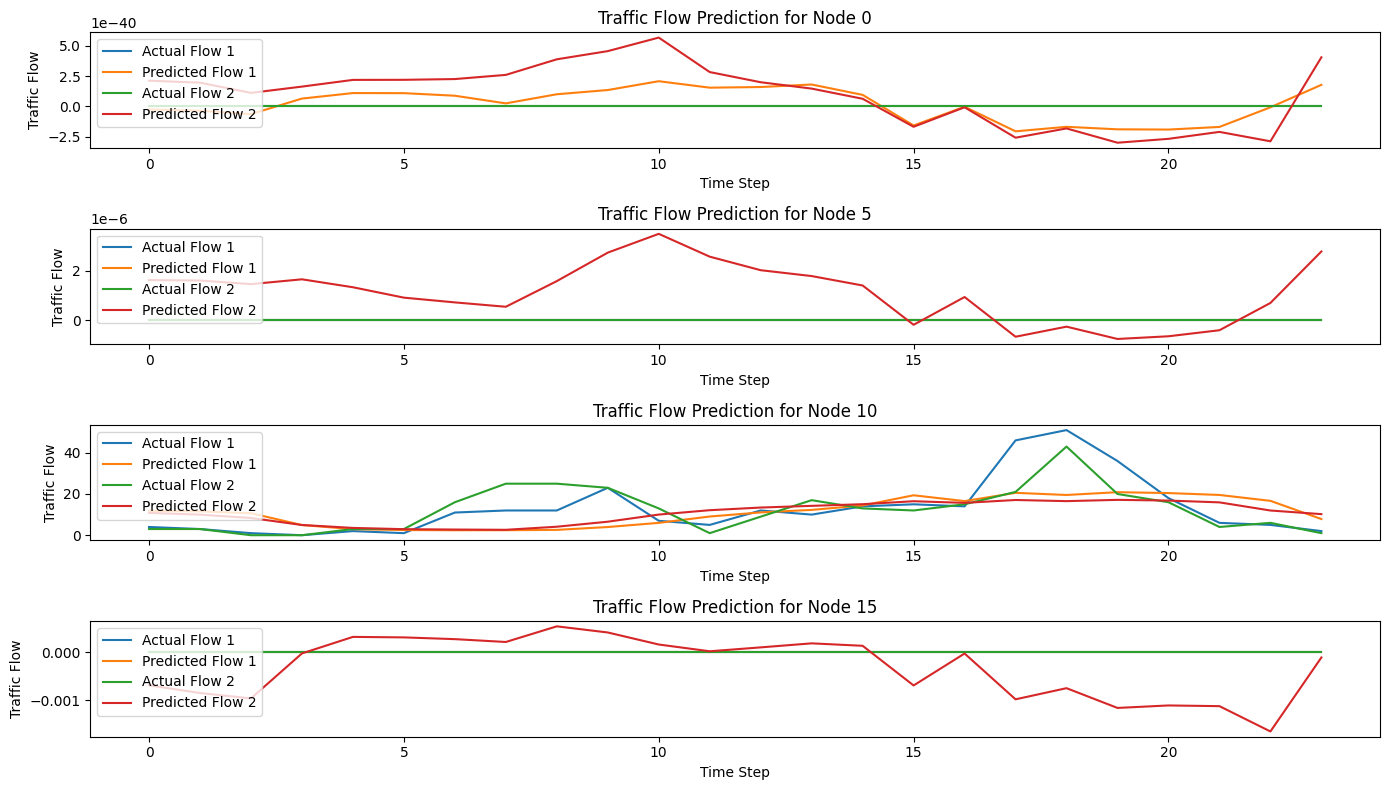

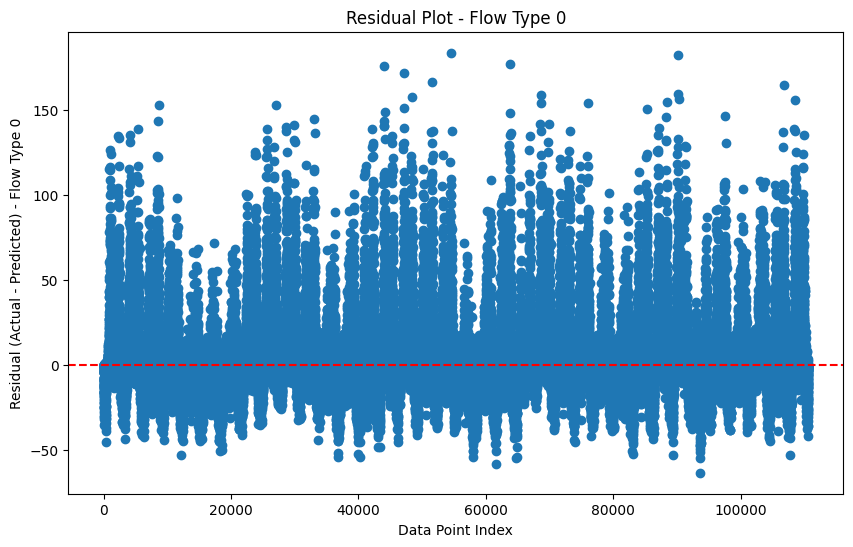

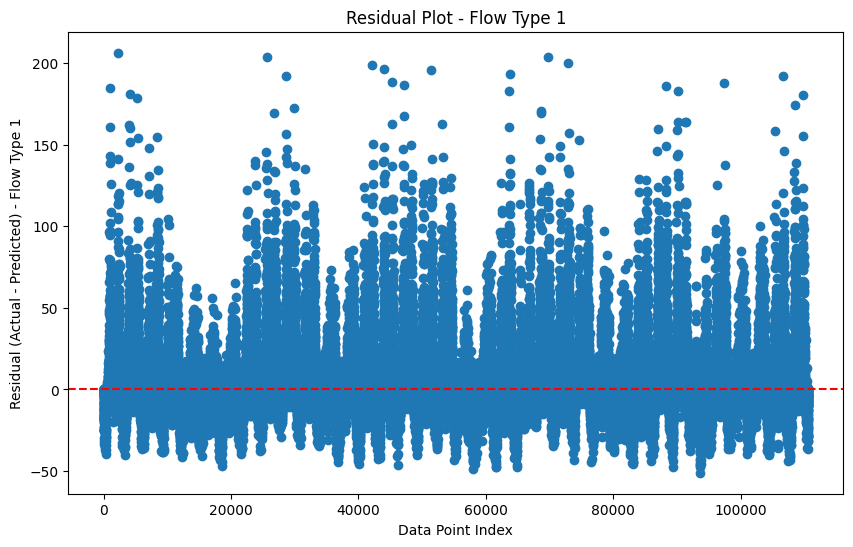

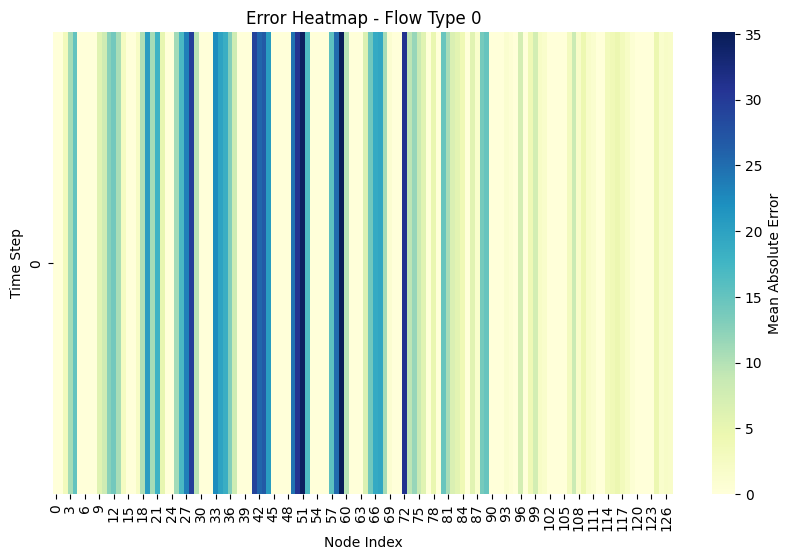

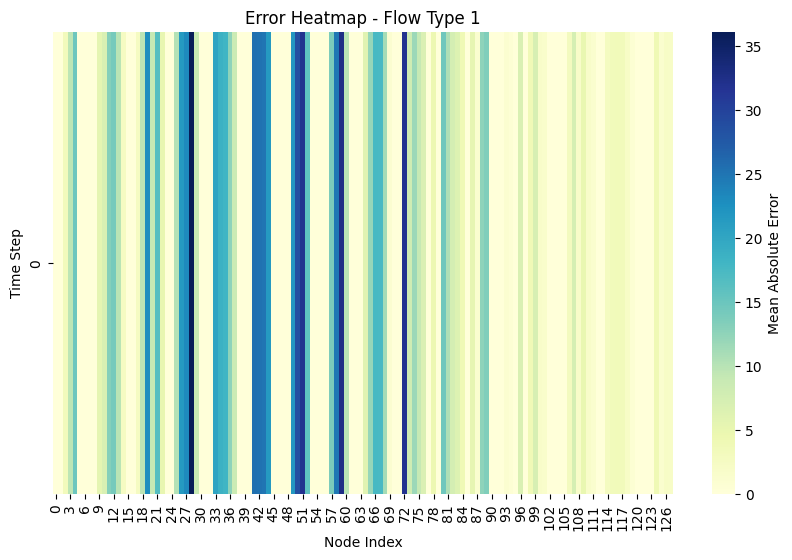

In [ ]:
# --- 3. Visualizations ---

# --- (a) Time Series Predictions for Multiple Nodes ---
def plot_time_series_predictions(y_true, y_pred, nodes_to_visualize=[0, 5, 10, 15], num_time_steps=24):

    y_true = y_true.reshape(-1, num_nodes, flow_types)
    y_pred = y_pred.reshape(-1, num_nodes, flow_types)

    plt.figure(figsize=(14, 8))

    for i, node_index in enumerate(nodes_to_visualize):
        plt.subplot(len(nodes_to_visualize), 1, i+1)
        plt.plot(y_true[:num_time_steps, node_index, 0], label="Actual Flow 1")
        plt.plot(y_pred[:num_time_steps, node_index, 0], label="Predicted Flow 1")
        plt.plot(y_true[:num_time_steps, node_index, 1], label="Actual Flow 2")
        plt.plot(y_pred[:num_time_steps, node_index, 1], label="Predicted Flow 2")

        plt.xlabel("Time Step")
        plt.ylabel("Traffic Flow")
        plt.title(f"Traffic Flow Prediction for Node {node_index}")
        plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plot_time_series_predictions(all_targets, all_predictions)

# --- (b) Residual Plots ---
def plot_residuals(y_true, y_pred, flow_type=0):

    y_true = y_true.reshape(-1, num_nodes, flow_types)
    y_pred = y_pred.reshape(-1, num_nodes, flow_types)

    residuals = y_true[:, :, flow_type] - y_pred[:, :, flow_type]
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(residuals.flatten())), residuals.flatten())
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Data Point Index")
    plt.ylabel(f"Residual (Actual - Predicted) - Flow Type {flow_type}")
    plt.title(f"Residual Plot - Flow Type {flow_type}")
    plt.show()

plot_residuals(all_targets, all_predictions, flow_type=0)
plot_residuals(all_targets, all_predictions, flow_type=1)

# --- (c) Error Heatmap ---
def plot_error_heatmap(y_true, y_pred, flow_type=0):

    y_true = y_true.reshape(-1, num_nodes, flow_types)
    y_pred = y_pred.reshape(-1, num_nodes, flow_types)
    mae_matrix = np.mean(np.abs(y_true[:, :, flow_type] - y_pred[:, :, flow_type]), axis=0)
    mae_matrix = mae_matrix.reshape(-1, num_nodes)

    plt.figure(figsize=(10, 6))
    sns.heatmap(mae_matrix, cmap="YlGnBu", cbar_kws={'label': 'Mean Absolute Error'})
    plt.xlabel("Node Index")
    plt.ylabel("Time Step")
    plt.title(f"Error Heatmap - Flow Type {flow_type}")
    plt.title(f"Error Heatmap - Flow Type {flow_type}")
    plt.show()

plot_error_heatmap(all_targets, all_predictions, flow_type=0)
plot_error_heatmap(all_targets, all_predictions, flow_type=1)

# 11. Mounting Google Drive :
This cell connects our Google Colab environment to Google Drive. It allows us to access files stored in our Google Drive, enabling us to save or load data, models, and other files directly from our Drive storage. This is particularly useful for persisting our work across Colab sessions and for working with larger datasets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 12. Saving model to Google Drive :
In this cell We save our trained model's state dictionary to a file named 'gcn_lstm_simclr_model.pth' in our Google Drive. By storing the model parameters, we can later reload the model to resume training, make predictions, or share our work without needing to retrain. This step is crucial for preserving our progress and ensuring we can easily access our model in future sessions.

In [ ]:
model = GCN_LSTM_SimCLR(num_nodes, num_features, hidden_dim, projection_dim, flow_types)
linear_model = LinearEvaluator(input_dim=hidden_dim, num_classes=num_nodes * flow_types)
torch.save(model.state_dict(), '/content/drive/MyDrive/gcn_lstm_simclr_model.pth')
torch.save(linear_model.state_dict(), '/content/drive/MyDrive/linear_model.pth')
torch.save(model.state_dict(), '/content/drive/MyDrive/best_encoder_model2.pth')
torch.save(linear_model.state_dict(), '/content/drive/MyDrive/best_linear_model2.pth')
torch.save(linear_model.state_dict(), '/content/drive/MyDrive/best_finetune_gcn_lstm_model.pth')

# 13. loading the state dictionaries :
loading the models saved in google drive

In [ ]:
import torch
model = torch.load('/content/drive/MyDrive/best_encoder_model2.pth')
linear_model = torch.load('/content/drive/MyDrive/best_linear_model2.pth')

<ipython-input-22-a3f77a41034c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/best_encoder_model2.pth')
<ipython-input-22-a3f77